In [1]:
# Loading in the necessary libraries 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import numpy as np
import re

import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix


nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bensioninoyatov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/bensioninoyatov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/bensioninoyatov/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
main = pd.read_csv('main1.csv')
main.drop(columns='Unnamed: 0', inplace=True)

In [186]:
main.head()

,text,label
0,You Can Smell Hillary’s Fear Daniel Greenfield...,1
1,Watch The Exact Moment Paul Ryan Committed Pol...,1
2,Kerry to go to Paris in gesture of sympathy U....,0
3,Bernie supporters on Twitter erupt in anger ag...,1
4,The Battle of New York: Why This Primary Matte...,0


## Vectorizing 
- TF-IDF vectorizing is used in this notebook for the modelling process using the ```stop_words``` parameter
- ```ngram_range``` to include both single words and two word combinations 
- this type of vectorization results in very sparse matrices so ```max_df``` is set to 75%

In [236]:
# Importing stop words and punctuations to remove from text 
import string
from nltk.corpus import stopwords

stopwords = stopwords.words('english')
stopwords += list(string.punctuation)
stopwords += ['’', '“', '”', '–', "'s", "''", '—', '``', '‘', '``']

In [306]:
# Instantiating the tfidf object
tfidf_vectorizer=TfidfVectorizer(stop_words=stopwords, ngram_range=(1,2), max_df=.75)

### Dummy Classifier to start

In [238]:
X = main['text']
y = main['label']
Xvec = tfidf_vectorizer.fit_transform(X)
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(Xvec,y)
dummy_clf.predict(Xvec)
dummy_clf.score(Xvec, y)

0.5108900444645414

- As expected the dummy classifier guesses towards the most frequent class at best 
---
### Passive Aggressive Classifier (PAC)
- No lemming/stemming 
- only removed stop words in the tfidf object

In [307]:
# Splitting into train and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.33, random_state=1, shuffle=True)

In [308]:
# Vectorizing data so that we can use it in model process 
vec_train=tfidf_vectorizer.fit_transform(X_train)
vec_test=tfidf_vectorizer.transform(X_test)

In [309]:
# Instantiating the classifier and fitting vectorized data 
pac=PassiveAggressiveClassifier(max_iter=50, random_state=1, C=2)
pac.fit(vec_train,y_train)

PassiveAggressiveClassifier(C=2, max_iter=50, random_state=1)

In [310]:
# Predicting on the test data and getting an accuracy score 
y_pred=pac.predict(vec_test)
score=accuracy_score(y_test,y_pred)
print(f'PAC Accuracy: {round(score*100,2)}')
score

PAC Accuracy: 97.0


0.9699703128568167

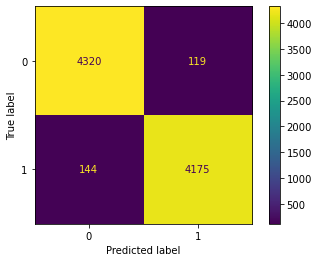

In [384]:
plot_confusion_matrix(pac, vec_test, y_test)
plt.savefig('model_confusion_matrix.png')

In [312]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      4439
           1       0.97      0.97      0.97      4319

    accuracy                           0.97      8758
   macro avg       0.97      0.97      0.97      8758
weighted avg       0.97      0.97      0.97      8758



- So far, accuracy is great with term frequency vectorizing. Further processing may improve this score 
---
### PAC lemmatization
- ```lemma_text``` taken from the ```eda_and_cleaning``` notebook

In [313]:
lemma_text = pd.read_csv('lemma_text.csv')
lemma_text.drop(columns='Unnamed: 0', inplace=True)
lemma_text.head()

,text
0,smell hillary fear daniel greenfield shillman ...
1,watch exact moment paul ryan committed politic...
2,kerry go paris gesture sympathy u.s. secretary...
3,bernie supporter twitter erupt anger dnc 'we t...
4,battle new york primary matter primary day new...


In [314]:
# Splitting into train and test sets for new lemma data 
X_train_lemma, X_test_lemma, y_train, y_test = train_test_split(lemma_text['text'], main['label'], 
                                                    test_size = 0.33, random_state=1, shuffle=True)

In [315]:
# Vectorizing data so that we can use it in model process 
vec_train3=tfidf_vectorizer.fit_transform(X_train_lemma)
vec_test3=tfidf_vectorizer.transform(X_test_lemma)

In [322]:
# Instantiating the classifier and fitting to the new vectorized data 
pac3=PassiveAggressiveClassifier(max_iter=50, random_state=1, C=.055, class_weight='balanced')
pac3.fit(vec_train3, y_train)

PassiveAggressiveClassifier(C=0.055, class_weight='balanced', max_iter=50,
                            random_state=1)

In [323]:
# Predicting on the new test data and getting an accuracy score 
y_pred3=pac3.predict(vec_test3)
score=accuracy_score(y_test,y_pred3)
print(f'PAC Accuracy: {round(score*100,2)}')
score

PAC Accuracy: 96.87


0.96871431833752

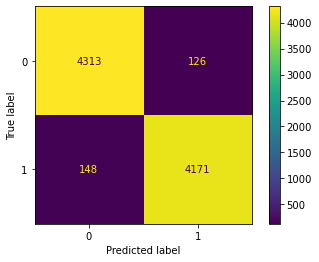

In [324]:
plot_confusion_matrix(pac3, vec_test3, y_test)

In [325]:
print(classification_report(y_test, y_pred3, digits=3))

              precision    recall  f1-score   support

           0      0.967     0.972     0.969      4439
           1      0.971     0.966     0.968      4319

    accuracy                          0.969      8758
   macro avg      0.969     0.969     0.969      8758
weighted avg      0.969     0.969     0.969      8758



- Lemmatized words performed just a bit worse but only marginally 
### PAC with stemming 

In [326]:
stem_text = pd.read_csv('stem_text.csv')
stem_text.drop(columns='Unnamed: 0', inplace=True)
stem_text.head()

,text
0,smell hillari fear daniel greenfield shillman ...
1,watch exact moment paul ryan commit polit suic...
2,kerri go pari gestur sympathi u.s. secretari s...
3,berni support twitter erupt anger dnc 'we tri ...
4,battl new york primari matter primari day new ...


In [327]:
X_train, X_test, y_train, y_test = train_test_split(stem_text['text'], main['label'], random_state=1, 
                                                    shuffle=True, test_size = 0.33)

vec_train=tfidf_vectorizer.fit_transform(X_train)
vec_test=tfidf_vectorizer.transform(X_test)

In [328]:
pacStem=PassiveAggressiveClassifier(max_iter=1000, random_state=1, C=1, class_weight='balanced', shuffle=True)
pacStem.fit(vec_train, y_train)

PassiveAggressiveClassifier(C=1, class_weight='balanced', random_state=1)

In [329]:
ypredstem = pacStem.predict(vec_test)
score = accuracy_score(y_test, ypredstem)
print(f'PAC Accuracy: {round(score*100,2)}')
score

PAC Accuracy: 96.79


0.9679150490979676

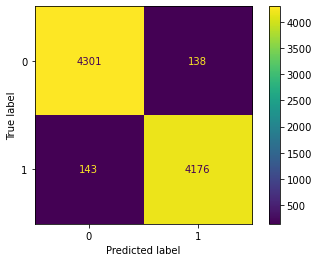

In [330]:
plot_confusion_matrix(pacStem, vec_test, y_test);

In [331]:
print(classification_report(y_test, ypredstem, digits=3))

              precision    recall  f1-score   support

           0      0.968     0.969     0.968      4439
           1      0.968     0.967     0.967      4319

    accuracy                          0.968      8758
   macro avg      0.968     0.968     0.968      8758
weighted avg      0.968     0.968     0.968      8758



---
### Random Forest with gridsearchcv

In [72]:
from sklearn.ensemble import RandomForestClassifier

In [335]:
X = main['text']
y = main['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.33, random_state=1, shuffle=True)

vec_train=tfidf_vectorizer.fit_transform(X_train)
vec_test=tfidf_vectorizer.transform(X_test)

rfc = RandomForestClassifier(criterion='entropy', max_depth = 100, n_estimators = 200, 
                             verbose=1, n_jobs=-1, random_state=1)
rfc.fit(vec_train, y_train)
ypred = rfc.predict(vec_test)
accuracy_score(y_test, ypred)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   46.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  3.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   20.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   21.4s finished


0.9229276090431605

In [80]:
rfc = RandomForestClassifier(verbose=1, n_jobs=-1, random_state=1)
param = {'n_estimators': range(50,200,25),
         'max_depth' : range(5,50,10),
         'criterion': ['gini', 'entropy']}
rfcgs = GridSearchCV(rfc, param, n_jobs=-1, verbose=1, cv=3)
rfcgs.fit(vec_train, y_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 27.1min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:   27.3s finished


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(n_jobs=-1, random_state=1,
                                              verbose=1),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(5, 50, 10),
                         'n_estimators': range(50, 200, 25)},
             verbose=1)

In [81]:
rfcgs.best_params_

{'criterion': 'entropy', 'max_depth': 45, 'n_estimators': 175}

In [83]:
rfc = RandomForestClassifier(criterion = 'entropy', max_depth = 100,
                             verbose=1, n_jobs=-1, random_state=1,
                            n_estimators=175)
rfc.fit(vec_train,y_train)
ypred = rfc.predict(vec_test)
accuracy_score(y_test, ypred)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:   48.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 175 out of 175 | elapsed:    2.8s finished


0.9351921627731725

---
- PAC performed best 

---
### Visualization

In [336]:
import string
from nltk.corpus import stopwords

stopwords = stopwords.words('english')
stopwords += list(string.punctuation)
stopwords += ['’', '“', '”', '–', "'s", "''", '—', '``', '‘', '``', '‘', 'в', "n't"]

In [337]:
freq_fake = main[main['label']==1]
freq_real = main[main['label']==0]

In [338]:
data_fake = freq_fake['text']
data_real = freq_real['text']

In [339]:
def process_article1(article):
    article = article.lower()
    tokens = nltk.word_tokenize(article)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords]
    return stopwords_removed
cleaned_fake = list(map(process_article1, data_fake))
cleaned_real = list(map(process_article1, data_real))

In [340]:
flat_fake = [item for sublist in cleaned_fake for item in sublist]
flat_true = [item for sublist in cleaned_real for item in sublist]

In [341]:
fake_freq = FreqDist(flat_fake)
real_freq = FreqDist(flat_true)

In [342]:
fake_freq.most_common(200)

[('trump', 27733),
 ('clinton', 26677),
 ('people', 21789),
 ('one', 20432),
 ('us', 19435),
 ('would', 19401),
 ('hillary', 18448),
 ('said', 15771),
 ('new', 14360),
 ('like', 13284),
 ('also', 13031),
 ('world', 12284),
 ('even', 11656),
 ('election', 11485),
 ('time', 11482),
 ('state', 11233),
 ('government', 10540),
 ('many', 10518),
 ('president', 10460),
 ('could', 10126),
 ('2016', 10116),
 ('war', 9970),
 ('obama', 9890),
 ('russia', 8993),
 ('american', 8970),
 ('states', 8752),
 ('media', 8650),
 ('years', 8582),
 ('get', 8433),
 ('first', 8414),
 ('campaign', 8097),
 ('u.s.', 8096),
 ('know', 7835),
 ('may', 7827),
 ('two', 7559),
 ('donald', 7452),
 ('news', 7373),
 ('america', 7340),
 ('way', 7213),
 ('fbi', 7183),
 ('see', 7177),
 ('make', 7121),
 ('country', 7058),
 ('going', 6915),
 ('political', 6886),
 ('de', 6685),
 ('united', 6658),
 ('well', 6644),
 ('think', 6517),
 ('much', 6433),
 ('right', 6239),
 ('back', 6153),
 ('white', 6144),
 ('take', 6136),
 ('day', 60

In [343]:
real_freq.most_common(200)

[('said', 85402),
 ('mr.', 65016),
 ('trump', 54317),
 ('new', 32252),
 ('would', 30922),
 ('one', 29028),
 ('people', 26299),
 ('president', 23089),
 ('also', 20565),
 ('like', 19950),
 ('clinton', 19352),
 ('state', 17756),
 ('could', 16249),
 ('time', 15583),
 ('states', 14986),
 ('two', 14867),
 ('many', 14585),
 ('york', 14437),
 ('first', 14408),
 ('years', 14234),
 ('obama', 14040),
 ('last', 13856),
 ('times', 13818),
 ('even', 13683),
 ('campaign', 12786),
 ('year', 12662),
 ('ms.', 12471),
 ('news', 12327),
 ('house', 12178),
 ('united', 12142),
 ('american', 11669),
 ('government', 11174),
 ('percent', 10314),
 ('get', 10207),
 ('going', 10206),
 ('white', 10194),
 ('republican', 10170),
 ('country', 9976),
 ('say', 9931),
 ('may', 9905),
 ('made', 9868),
 ('party', 9847),
 ('told', 9715),
 ('make', 9703),
 ('back', 9565),
 ('political', 9399),
 ('think', 9328),
 ('way', 9274),
 ('much', 9266),
 ('national', 8827),
 ('still', 8805),
 ('former', 8783),
 ('police', 8723),
 ('w

In [346]:
fake_bar_counts = [x[1] for x in fake_freq.most_common(25)]
fake_bar_words = [x[0] for x in fake_freq.most_common(25)]

real_bar_counts = [x[1] for x in real_freq.most_common(25)]
real_bar_words = [x[0] for x in real_freq.most_common(25)]

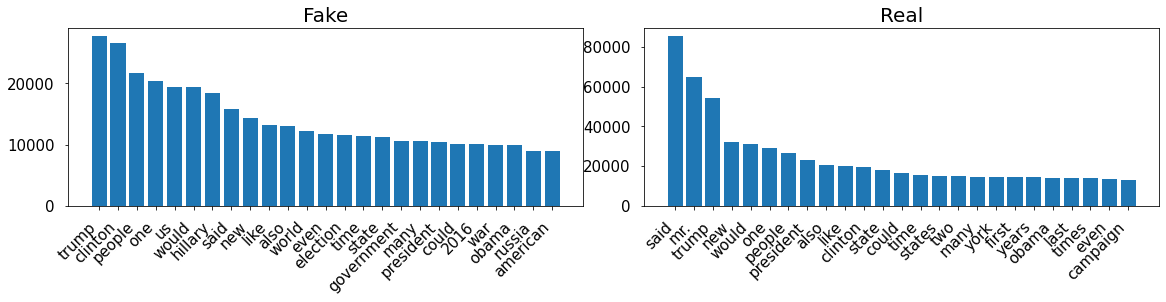

In [397]:
new_figure = plt.figure(figsize=(16,4))

ax = new_figure.add_subplot(121)
ax2 = new_figure.add_subplot(122)

# Generate a line plot on first axes
ax.bar(fake_bar_words, fake_bar_counts)
# ax.plot(colormap='PRGn')

# Draw a scatter plot on 2nd axes
ax2.bar(real_bar_words, real_bar_counts)

ax.set_title('Fake', fontsize=20)
ax2.set_title('Real', fontsize=20)


plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
plt.setp(ax2.get_xticklabels(), ha="right", rotation=45)
ax.tick_params(labelsize=15, pad=10)
ax2.tick_params(labelsize=15, pad=10)

plt.tight_layout(pad=0)

plt.savefig('word_count_bar_graphs.png')

plt.show()

In [390]:
from wordcloud import WordCloud
fake_dictionary = dict(zip(fake_bar_words, fake_bar_counts))
real_dictionary = dict(zip(real_bar_words, real_bar_counts))

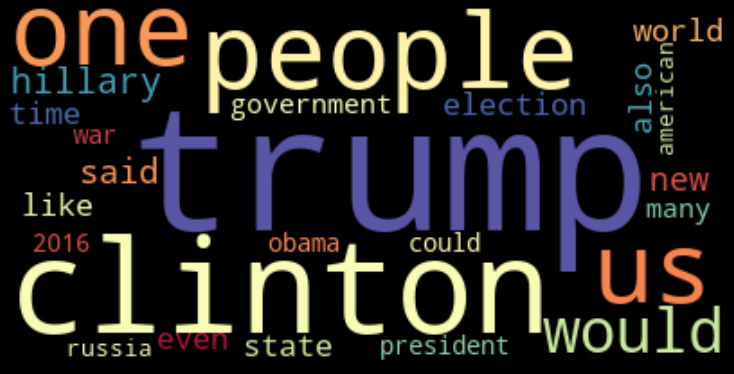

In [381]:
wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(fake_dictionary)

plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

# Uncomment the next line if you want to save your image:
plt.savefig('fake_wordcloud.png')

plt.show()

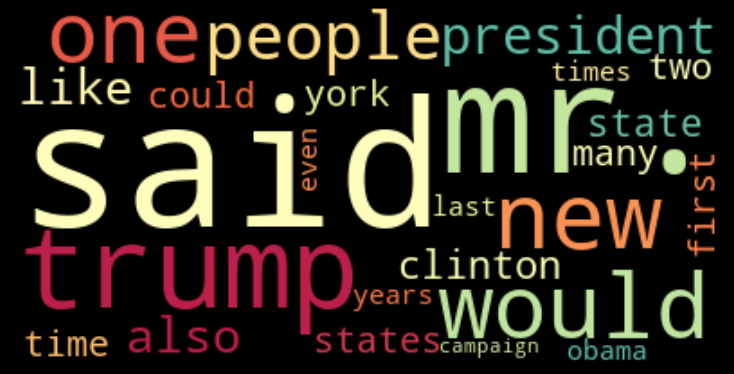

In [383]:
wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(real_dictionary)

plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

# Uncomment the next line if you want to save your image:
plt.savefig('real_wordcloud.png')

plt.show()